In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import warnings
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from grid import regridXYZ, regridXYZMasked
from rotate import shiftRotateXYZ
from parabolas import loadLeicaData
from zernikies import getZernikeCoeffs, zernikePoly, zernikeFitLS
from utils.utils import midPoint, gridLimits, getRollingStat
from plotting import surfacePlot, barChartPlot
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [4]:
def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xr, yr, zr = shiftRotateXYZ(x, y, z, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    xg, yg, zg = regridXYZ(xr, yr, zr, n=n)
    
    return xg, yg, zg

In [5]:
n = 512
nZern = 36
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'
ref_scans = ['2020_03_16_02:21:06',
             '2020_03_16_02:54:59',
             '2020_03_16_03:19:50',
             '2020_03_16_03:44:25',
             '2020_03_16_04:09:06',
             '2020_03_16_04:33:33',
             '2020_03_16_04:58:03',
             '2020_03_16_05:22:24',
             '2020_03_16_05:47:09',
             '2020_03_16_06:11:20',
             '2020_03_16_06:35:42',
             '2020_03_16_07:00:20',
             '2020_03_16_07:24:39',
             '2020_03_16_07:48:47',
             '2020_03_16_08:12:50',
             '2020_03_16_08:37:03',
             '2020_03_16_09:01:35',
            ]

In [6]:
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=178.)

In [7]:
%%time

# Use the .zernike.fits files to select signal scans.
fitsDir = '/home/gbtdata/TLASSI_200315'
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

zFitDict = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,ff in enumerate(zern_files):
        
        time = Time( '{0}T{1}'.format('-'.join(ff.split('/')[-1].split('.')[0].split("_")[:3]), 
                                  ff.split('/')[-1].split('.')[0].split("_")[-1]) )
        mjd = time.mjd

        sf = ff.replace(".zernike.fits", ".fits")
        sigScanFile = "{0}/{1}".format(scanDir, sf.split('/')[-1].replace('.fits', '.ptx.csv'))

        # Find the scan number.
        hdu = fits.open(sf)
        head = hdu[0].header
        scan = head['SCAN']

        xs, ys, zs = prepareData(sigScanFile, n=n, rot=178.)

        xmin, xmax = gridLimits(xs, xr)
        ymin, ymax = gridLimits(ys, yr)
        xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
        xsg, ysg, zsg = regridXYZ(xs, ys, zs, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
        
        diff = sigma_clip(np.ma.masked_invalid(zsg - zrg), 3)
        
        #x, y, d = regridXYZMasked(xrg, yrg, diff, n=64)
        #zfit = zernikeFitLS(x[~np.isnan(d.filled(np.nan))], y[~np.isnan(d.filled(np.nan))], 
        #                    d[~np.isnan(d.filled(np.nan))], np.zeros(nZern))
        
        fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')
        
        diff_ = np.ma.copy(diff)
        fl_fs_sub = np.copy(fl_fs)
        it = 0
        while np.any(abs(fl_fs_sub[2:4]) > 100e-6):
            #fl_fs_sub[1] *= 0.
            fl_fs_sub[2] *= -1.
            zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), fl_fs_sub[0:4])
            diff_ = diff_ - zpoly_
            fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
            it += 1
        
        diff5 = sigma_clip(np.ma.masked_invalid(zsg - zrg), 5)
        
        window = (20,20)
        diff_pad = np.pad(diff5.filled(np.nan), (window,window), constant_values=np.nan)
        diff_pad = np.ma.masked_invalid(diff_pad)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            diff_rms = getRollingStat(diff_pad, func=np.nanstd, window=window)
            diff_avg = getRollingStat(diff_pad, func=np.nanmean, window=window)
        diff_rms = diff_rms[window[0]:-window[1],window[0]:-window[1]]
        diff_avg = diff_avg[window[0]:-window[1],window[0]:-window[1]]
        diff_rms = np.ma.masked_where(diff_rms == 0, diff_rms)
        mask = (abs(diff5 - diff_avg)/diff_rms > 2) | (diff_rms == 0)
        mdiff = np.ma.masked_where(mask, diff5)
        
        mfl_fs = getZernikeCoeffs(mdiff.filled(0)[::-1].T, nZern, norm='active-surface')
        
        mdiff_ = np.ma.copy(mdiff)
        mfl_fs_sub = np.copy(mfl_fs)
        it = 0
        while np.any(abs(mfl_fs_sub[2:4]) > 100e-6):
            #fl_fs_sub[1] *= 0.
            mfl_fs_sub[2] *= -1.
            zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), mfl_fs_sub[0:4])
            mdiff_ = mdiff_ - zpoly_
            mfl_fs_sub = getZernikeCoeffs(mdiff_.filled(0)[::-1].T, 36, norm='active-surface')
            it += 1
        
        #fl_fs_sub[2] *= -1.
        #zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), fl_fs_sub[:4])
        #diff_ = diff - zpoly_
        #fl_fs_ = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
        
        zFitDict[scan] = {'recovered zernike': fl_fs,
                          'recovered zernike tilt subtracted': fl_fs_sub,
                          'recovered zernike masked': mfl_fs,
                          'recovered zernike masked tilt subtracted': mfl_fs_sub,
                          #'recovered zernike LS': zfit.x,
                          'mjd': mjd
                         }

CPU times: user 29min 28s, sys: 1min 30s, total: 30min 58s
Wall time: 28min 50s


In [8]:
%%time

asDict = {}

# Use the .zernike.fits files to select signal scans.
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

# Load the ScanLog
hdu = fits.open("{0}/ScanLog.fits".format(fitsDir))
scanArr = hdu[1].data

for i, zf in enumerate(zern_files):
    
    hdu = fits.open(zf)
    head = hdu[0].header
    scan = head['MC_SCAN']

    idx = np.where(scanArr['SCAN'] == scan)[0][0]
    idx_as = idx - 3
    sig_scan = scanArr['SCAN'][idx_as]
    ref_scan = scanArr['SCAN'][idx_as-6]

    # Load the AS fits file for the signal scan.
    as_file = file = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    hdu = fits.open("{0}/{1}".format(fitsDir, as_file))
    z_as = hdu[1].data['value']

    # The AS Zernike contents start at Z1, not Z0.
    # The LASSI Zernike start at Z0.
    z_idx = int(np.where(z_as != 0)[0])

    as_file_sig = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    as_file_ref = '/'.join(scanArr[idx_as - 6]['FILEPATH'].split('/')[-2:])
    #print(as_file_sig, as_file_ref)
    xas, yas, aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/{1}".format(fitsDir, as_file_ref), 
                                                               "{0}/{1}".format(fitsDir, as_file_sig), 
                                                               column='ABSOLUTE', filterDisabled=True, 
                                                               verbose=False, plot=False)
    z_as_obs = fitlist

    z_in = z_as[z_idx]
    z_in_as = z_as_obs[z_idx+1]*1e6 # microns

    asDict[scan] = {'input zernike': z_idx + 1,
                    'input zernike value': z_as[z_idx],
                    'active surface zernike value': z_in_as,
                    'active surface reference scan': ref_scan,
                    'active surface signal scan': sig_scan,
                     }

CPU times: user 30 s, sys: 2.41 s, total: 32.4 s
Wall time: 28.5 s


In [9]:
%%time
zindxs = [4, 7, 13]
zcoefs = np.arange(0., 500., 10.)*1e-6 # m
eps_tot, eta_tot = make_aperture_efficiency(zindxs, zcoefs, n=256, eps=225e-6)

CPU times: user 42.6 s, sys: 6.6 ms, total: 42.6 s
Wall time: 42.6 s


In [10]:
%%time

zin = np.zeros(len(zern_files), dtype=np.float)
mjds = np.zeros(len(zern_files), dtype=np.float)
zobs = np.zeros((len(zern_files),4), dtype=np.float)
zinval = np.zeros(len(zern_files), dtype=np.float)
residuals = np.zeros((len(zern_files),2), dtype=np.float)

for i,k in enumerate(natsorted(list(zFitDict.keys()))):
    
    zi = asDict[k]['input zernike']
    ci = asDict[k]['active surface zernike value']
    if zi == 7:
        ci *= -1
    ci_obs = zFitDict[k]['recovered zernike'][zi]
    ci_obs_ = zFitDict[k]['recovered zernike tilt subtracted'][zi]
    ci_obs_m = zFitDict[k]['recovered zernike masked'][zi]
    ci_obs_m_ts = zFitDict[k]['recovered zernike masked tilt subtracted'][zi]
    #ci_obs_ls = zFitDict[k]['recovered zernike LS'][zi]
    #if zi == 7:
    #    ci_obs_ls *= -1
    mjds[i] = zFitDict[k]['mjd']
    
    zin[i] = zi
    zinval[i] = ci
    zobs[i,0] = ci_obs
    zobs[i,1] = ci_obs_
    zobs[i,2] = ci_obs_m
    zobs[i,3] = ci_obs_m_ts
    #zobs[i,2] = ci_obs_ls
    residuals[i,0] = abs(ci - ci_obs)
    residuals[i,1] = abs(ci - ci_obs_)

CPU times: user 864 µs, sys: 29 µs, total: 893 µs
Wall time: 903 µs


In [11]:
time = Time(mjds, format='mjd')
eta_res_0 = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,0]*1e6)
eta_res_1 = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,1]*1e6)
eta_res_2 = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,2]*1e6)
eta_res_3 = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,3]*1e6)
eta_res_comb = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs.mean(axis=1)*1e6)

In [12]:
np.savetxt("March2020_Ci_in_out_no_align.txt", np.c_[mjds, zin, zinval, zobs[:,1]*1e6, eta_res_1])

<IPython.core.display.Javascript object>


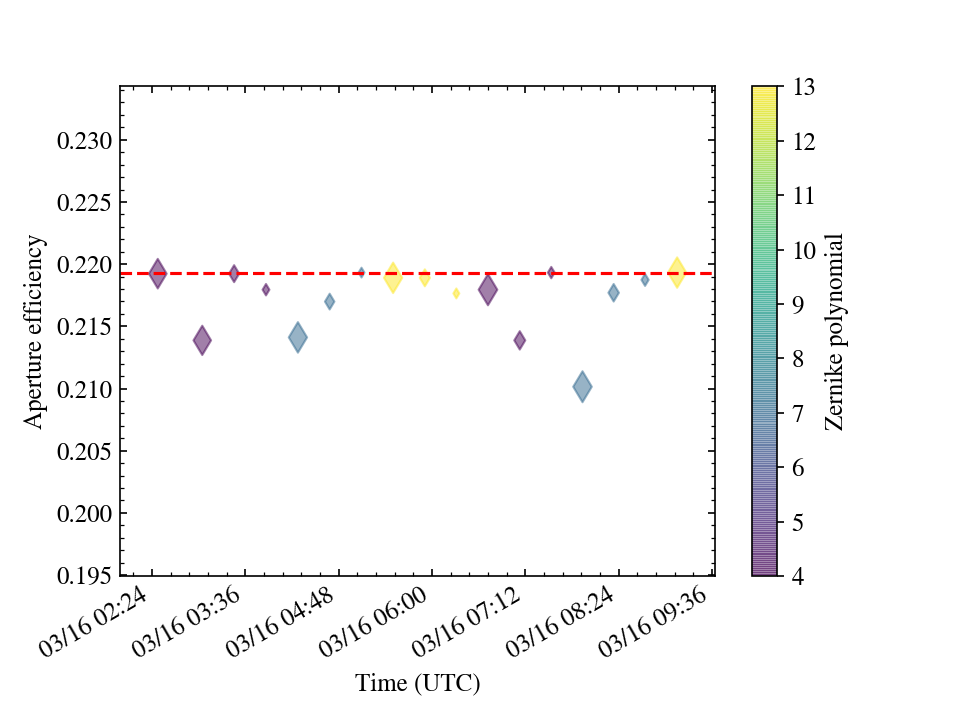

In [13]:
from matplotlib.dates import DateFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

formatter = DateFormatter('%m/%d %H:%M')

fig = plt.figure(dpi=150, frameon=False)

ax = fig.add_subplot(111)
#axt = ax.twiny()

ax.axhline(y=np.max(eta_tot), color='r', linestyle='--')
#sc = ax.scatter(time.plot_date, eta_res_0, c=zin, s=abs(zinval)/5., marker='o')
sc = ax.scatter(time.plot_date, eta_res_1, c=zin, s=abs(zinval)/5., marker='d', alpha=0.5)
#sc = ax.scatter(time.plot_date, eta_res_2, c=zin, s=abs(zinval)/5., marker='.', alpha=0.5)
#sc = ax.scatter(time.plot_date, eta_res_3, c=zin, s=abs(zinval)/5., marker='s')
cb = plt.colorbar(sc)
cb.set_label('Zernike polynomial')
ax.minorticks_on()
ax.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)
#ax.set_xlabel("Scan")
ax.set_ylabel("Aperture efficiency")

ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time (UTC)')

fig.autofmt_xdate()


#plt.savefig("eta_scan_avgrefsimple.pdf", bbox_inches='tight', pad_inches=0.06)

In [24]:
idx = -4
print(zin[idx], zinval[idx], zobs[idx]*1e6, zobs[idx].mean()*1e6)

7.0 -554.3320312960374 [-398.32162207 -437.40663327 -562.97760226 -560.78080646] -489.8716660136942


In [15]:
print(np.max(eta_tot), np.mean(eta_res_0), np.power(np.mean(eta_res_0)/np.max(eta_tot), -2.))

0.21932075789662847 0.21651208621222048 1.026112992371083


In [16]:
print(np.max(eta_tot), np.mean(eta_res_1), np.power(np.mean(eta_res_1)/np.max(eta_tot), -2.))

0.21932075789662847 0.21724631342156991 1.0191888063246783


In [17]:
print(np.max(eta_tot), np.mean(eta_res_2), np.power(np.mean(eta_res_2)/np.max(eta_tot), -2.))

0.21932075789662847 0.2144603257039072 1.0458407353361696


In [18]:
print(np.max(eta_tot), np.mean(eta_res_3), np.power(np.mean(eta_res_3)/np.max(eta_tot), -2.))

0.21932075789662847 0.21439809269560087 1.0464479726537328


In [19]:
print(np.max(eta_tot), np.mean(eta_res_comb), np.power(np.mean(eta_res_comb)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res_comb[:7],eta_res_comb[8:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.21932075789662847 0.2172546459334755 1.0191106285718496
0.21932075789662847 0.21715175951108986 1.0200765658168198


In [20]:
60*1.05

63.0

In [21]:
zern_files[-4]

'/home/gbtdata/TLASSI_200315/LASSI/2020_03_16_07:56:13.zernike.fits'

In [22]:
list(zFitDict.keys())[10]

81

In [23]:
asDict[81]

{'input zernike': 4,
 'input zernike value': 500.0,
 'active surface zernike value': -562.1026036575932,
 'active surface reference scan': 78,
 'active surface signal scan': 80}